# Salary and Identity Information Analysis for Atlanta City Employees (Capstone Project Submission)

* Student name: Konnor Clark
* Student pace: self paced
* Scheduled project review date/time:
* Instructor name: Morgan Jones
* Blog post URL: https://datadruid.blogspot.com/

## Project Goal:



This project uses identity information to analyze the salaries of Atlanta City employees. The goal of this created model is to help visualize and mitigate potential implicit bias in future salary tables to protect both employers and employees.

## Overview and Business Understanding/Questions



My stakeholder is the city of Atlanta, who wishes verify whether there is any bias in their current salary tables and wants to mitigate that potential implicit bias in future salary tables for their employees.  

Is there any implicit bias among the salaries of Atlanta City Employees?  

How can we mitigate any potential for implicit bias in our employees' salaries in the future?

## Data Source and Exploration



This data comes from Data World at the following site: https://data.world/brentbrewington/atlanta-city-employee-salaries. This dataset is from 2015.

Employee salary information along with identity information was gathered.

Most features in the dataset were used. These were:

 - age

 - sex

 - ethnic.origin
 
 - job.title
 
 - organization
 
 - annual.salary

The target feature is annual_salary.

## Importing, Previewing, and Cleaning the Data




In [30]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:
#Read the data and set variable
df = pd.read_csv('salaries.csv')

#Previw data
df.head()

,name,age,sex,ethnic.origin,job.title,organization,annual.salary
0,"Aaron, Dayan M",38,Male,Black or African American (Not Hispanic or Lat...,ATL311 Team Lead,EXE Executive Offices,45999.99
1,"Aaron, Freddie L",52,Male,Black or African American (Not Hispanic or Lat...,Environmental Service Worker I (D),DPW Department of Public Works,26700.10
2,"Aaron, Tyrone M",44,Male,Black or African American (Not Hispanic or Lat...,Watershed Crew Supervisor (D),DWM Department of Watershed Management,46575.01
3,"Abazenab, Kokeb",42,Female,Black or African American (Not Hispanic or Lat...,"Benefits Representative, Sr",DHR Department of Human Reources,42866.89
4,"Abbott, Christopher D",32,Male,White (Not Hispanic or Latino),Recreation Operations Assistant,"PRC Parks, Recreation, & Cultural Affairs",28035.05


While names could play a role in implicit bias, for the purposes of this project I'm simply going to remove this column for now. 

In [3]:
#Drop name column
df = df.drop(columns='name')

In [4]:
#Preview data
df.head()

,age,sex,ethnic.origin,job.title,organization,annual.salary
0,38,Male,Black or African American (Not Hispanic or Lat...,ATL311 Team Lead,EXE Executive Offices,45999.99
1,52,Male,Black or African American (Not Hispanic or Lat...,Environmental Service Worker I (D),DPW Department of Public Works,26700.10
2,44,Male,Black or African American (Not Hispanic or Lat...,Watershed Crew Supervisor (D),DWM Department of Watershed Management,46575.01
3,42,Female,Black or African American (Not Hispanic or Lat...,"Benefits Representative, Sr",DHR Department of Human Reources,42866.89
4,32,Male,White (Not Hispanic or Latino),Recreation Operations Assistant,"PRC Parks, Recreation, & Cultural Affairs",28035.05


In [5]:
#Check data for type and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            8246 non-null   int64  
 1   sex            8246 non-null   object 
 2   ethnic.origin  8246 non-null   object 
 3   job.title      8246 non-null   object 
 4   organization   8246 non-null   object 
 5   annual.salary  8246 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 386.7+ KB


Great, it looks like there are no null values and each type are what we would expect.

I'm curious as to the value_counts, so let's take a look.  Since age and annual.salary are numeric features, I'll drop them for this data exploration.

In [6]:
df2 = df.drop(columns=['age', 'annual.salary'])

#Extract value_counts for each feature
for column in df2:
    value_counts = df2[column].value_counts()
    print(f"Value counts for column '{column}':")
    print(value_counts)
    print()

Value counts for column 'sex':
Male      5461
Female    2785
Name: sex, dtype: int64

Value counts for column 'ethnic.origin':
Black or African American (Not Hispanic or Latino)           6304
White (Not Hispanic or Latino)                               1642
Hispanic or Latino of any race                                170
Asian (Not Hispanic or Latino)                                103
American Indian or Alaska Native (Not Hispanic or Latino)      13
Two or More Races (Not Hispanic or Latino)                     12
Native Hawaiian or Other Pacific                                2
Name: ethnic.origin, dtype: int64

Value counts for column 'job.title':
Police Officer (E) (F) (O) (B) (S)     1226
Firefighter (E)                         473
Police Investigator (E) (F) (O)         248
Fire Sergeant (E)                       230
Police Sergeant (E) (F) (O) (B) (S)     224
                                       ... 
Airport Public Affairs Director           1
Public Works, Commissioner     

We only have Male and Female in the sex column, and nearly double the number of males than females. 

We have 7 categories for ethnic.origin and the vast majority is Black or African American (Not Hispanic or Latino). 

In job.title we see that the majority of positions in this dataset are for police officers, and, relatedly, in organization the majority of entires have the APD or Atlanta Police Department.

Once we get to the cleaning state, it looks like we should remove the parentheticals from ethnic.origin and job.title and perhaps rephrase the values in organization, perhaps just to the organization's abbreviations. 

First, let's take a look at this value_count data as percentages. 

In [7]:
for column in df2:
    value_counts = df2[column].value_counts()
    total_count = value_counts.sum()
    percentages = value_counts / total_count * 100

    print(f"Value counts as percentages for column '{column}':")
    print(percentages)
    print()

Value counts as percentages for column 'sex':
Male      66.226049
Female    33.773951
Name: sex, dtype: float64

Value counts as percentages for column 'ethnic.origin':
Black or African American (Not Hispanic or Latino)           76.449187
White (Not Hispanic or Latino)                               19.912685
Hispanic or Latino of any race                                2.061606
Asian (Not Hispanic or Latino)                                1.249090
American Indian or Alaska Native (Not Hispanic or Latino)     0.157652
Two or More Races (Not Hispanic or Latino)                    0.145525
Native Hawaiian or Other Pacific                              0.024254
Name: ethnic.origin, dtype: float64

Value counts as percentages for column 'job.title':
Police Officer (E) (F) (O) (B) (S)     14.867815
Firefighter (E)                         5.736114
Police Investigator (E) (F) (O)         3.007519
Fire Sergeant (E)                       2.789231
Police Sergeant (E) (F) (O) (B) (S)     2.716469


We can see some of these skewed categories perhaps more easily now that we see the percentages. 

For ethnic.origin, Black or African American makes up 76.45% of the population of this data, which is in stark contrast to the demographic data of the country as a whole where Black or African Americans made up 13.8% of the population in 2015 (https://data.census.gov/table?tid=ACSDP5Y2015.DP05).  Similarly, where White people make up 19.91% of the population in this data, they made up 76.1% of the country in 2015. 

Police officers in this dataset make up 14.87% of the positions, and the police department 28.48%. 

Below I make a visuzliation for this information.  Since there are so many values for job.title, I'll remove it from the visualization for now. 

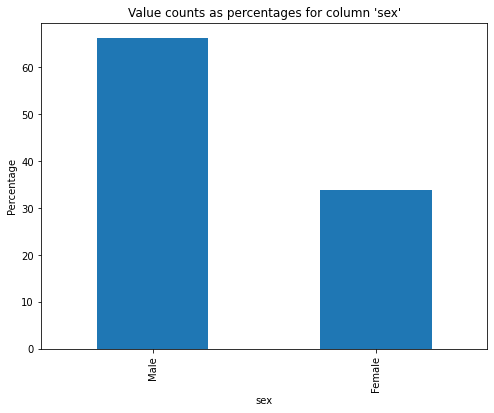

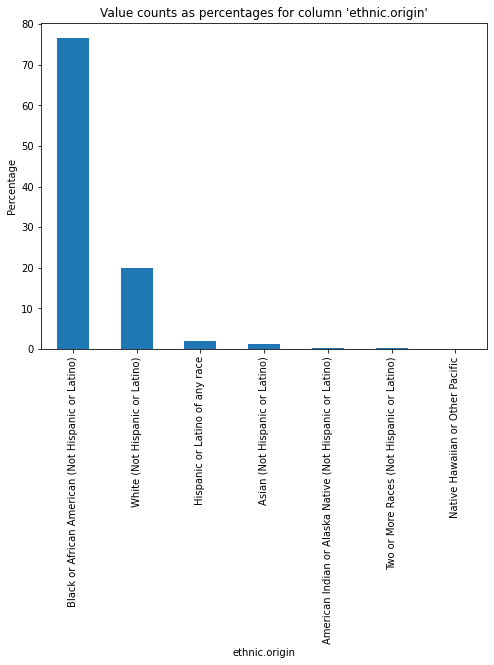

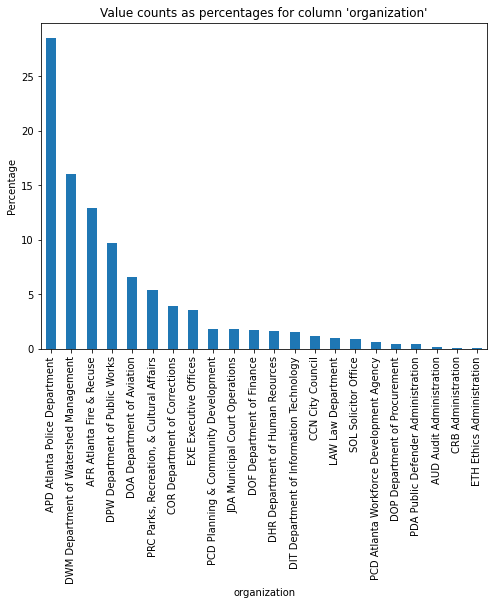

In [8]:
df3 = df2.drop(columns='job.title')

for column in df3:
    value_counts = df3[column].value_counts()
    total_count = value_counts.sum()
    percentages = value_counts / total_count * 100

    # Create a bar plot
    plt.figure(figsize=(8, 6))
    percentages.plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.title(f"Value counts as percentages for column '{column}'")
    plt.show()

Alright, I think the distribution of the data should be clear now.  Let's do something similar for age and annual_salary.

In [9]:
# Specify the columns of interest
columns_of_interest = ['age', 'annual.salary']

# Calculate and display statistics for the specified columns
column_stats = df[columns_of_interest].describe()
print(column_stats)

               age  annual.salary
count  8246.000000    8246.000000
mean     43.186636   49040.302659
std      11.236170   20042.032049
min      19.000000   20800.000000
25%      34.000000   36916.860000
50%      44.000000   43983.430000
75%      52.000000   55279.300000
max      89.000000  240697.600000


Intersting.  So the mean age is 43 with 49040 as the mean salary. We have a large range of ages from 19-89, but most are between 34 and 52. Salaries range from 20800 to 240697, but most are between 36916 and 55279.

Let's create some visualizations of the distributions of this data.

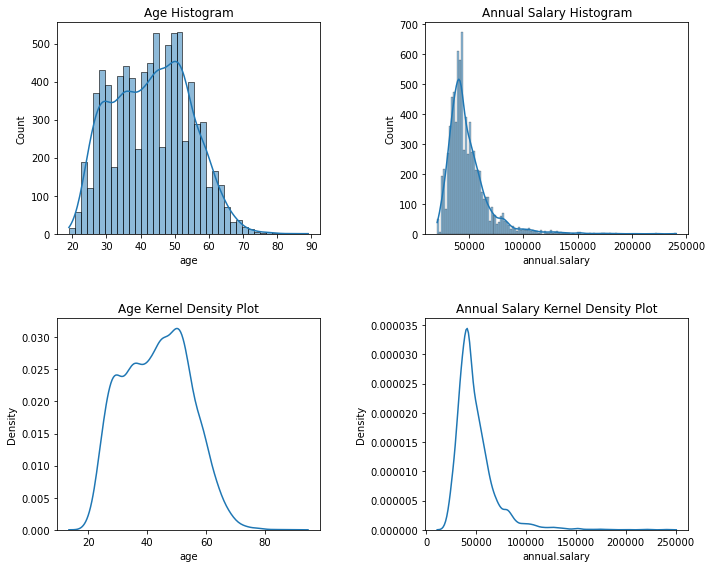

In [10]:
# Create subplots for the histograms and kernel density plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms for age and annual.salary
sns.histplot(data=df, x='age', kde=True, ax=axes[0, 0])
sns.histplot(data=df, x='annual.salary', kde=True, ax=axes[0, 1])

# Plot kernel density plots for age and annual.salary
sns.kdeplot(data=df, x='age', ax=axes[1, 0])
sns.kdeplot(data=df, x='annual.salary', ax=axes[1, 1])

# Set titles for the subplots
axes[0, 0].set_title('Age Histogram')
axes[0, 1].set_title('Annual Salary Histogram')
axes[1, 0].set_title('Age Kernel Density Plot')
axes[1, 1].set_title('Annual Salary Kernel Density Plot')

# Adjust spacing between subplots
plt.tight_layout()

# Remove scientific notation from the plot
plt.ticklabel_format(style='plain', axis='both')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Show the plots
plt.show()

Let's start cleaning.  First, I noticed that the AFR Atlanta Fire & Rescue department in the organization column was mislabeled as AFR Atlanta Fire & Recuse.  Let's fix that so that our values accurately represent the department. 

In [11]:
# Define the value to be replaced and its replacement
old_value = "AFR Atlanta Fire & Recuse"
new_value = "AFR Atlanta Fire & Rescue"

# Replace the specific value in the 'organization' column
df['organization'] = df['organization'].replace(old_value, new_value)

In [12]:
df.organization.value_counts()

APD Atlanta Police Department                2349
DWM Department of Watershed Management       1325
AFR Atlanta Fire & Rescue                    1063
DPW Department of Public Works                799
DOA Department of Aviation                    544
PRC Parks, Recreation, & Cultural Affairs     447
COR Department of Corrections                 320
EXE Executive Offices                         295
PCD Planning & Community Development          153
JDA Municipal Court Operations                147
DOF Department of Finance                     145
DHR Department of Human Reources              133
DIT Department of Information Technology      124
CCN City Council                               99
LAW Law Department                             82
SOL Solicitor Office                           74
PCD Atlanta Workforce Development Agency       50
DOP Department of Procurement                  40
PDA Public Defender Administration             34
AUD Audit Administration                       13


There we go.  No more recusing with fire.  Now let's remove the parentheticals.

In [13]:
# Specify the columns to process
columns_to_process = ["ethnic.origin", "job.title"]

for column in columns_to_process:
    df[column] = df[column].apply(lambda x: re.sub(r'\(.*?\)', '', str(x)))

# Print the updated dataframe
df.head()

,age,sex,ethnic.origin,job.title,organization,annual.salary
0,38,Male,Black or African American,ATL311 Team Lead,EXE Executive Offices,45999.99
1,52,Male,Black or African American,Environmental Service Worker I,DPW Department of Public Works,26700.10
2,44,Male,Black or African American,Watershed Crew Supervisor,DWM Department of Watershed Management,46575.01
3,42,Female,Black or African American,"Benefits Representative, Sr",DHR Department of Human Reources,42866.89
4,32,Male,White,Recreation Operations Assistant,"PRC Parks, Recreation, & Cultural Affairs",28035.05


In [14]:
#Verify data count remains the same
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            8246 non-null   int64  
 1   sex            8246 non-null   object 
 2   ethnic.origin  8246 non-null   object 
 3   job.title      8246 non-null   object 
 4   organization   8246 non-null   object 
 5   annual.salary  8246 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 386.7+ KB


In [15]:
#Verify removal of parentheses
df['ethnic.origin'].value_counts()

Black or African American            6304
White                                1642
Hispanic or Latino of any race        170
Asian                                 103
American Indian or Alaska Native       13
Two or More Races                      12
Native Hawaiian or Other Pacific        2
Name: ethnic.origin, dtype: int64

In [16]:
#Verify removal of parentheses
df['job.title'].value_counts()

Police Officer                        1226
Firefighter                            473
Police Investigator                    248
Fire Sergeant                          230
Police Sergeant                        224
                                      ... 
Watershed Management, Commissioner       1
Executive Safety Director                1
Water Utility Assistant Manager          1
Airport Security Director                1
City Auditor                             1
Name: job.title, Length: 769, dtype: int64

Great, so the parentheses have been removed!  

Let's simplify the organization to the abbreviations. First, I will print the list of unique values in this feature so that we can have it as a reference for posterity.

In [17]:
# Get the unique values in the 'organization' column and sort them alphabetically
unique_values = sorted(df['organization'].unique())

# Convert the sorted unique values to a list with each value on its own line
unique_values_list = '\n'.join(unique_values)

# Print the list of unique values
print(unique_values_list)

AFR Atlanta Fire & Rescue
APD Atlanta Police Department
AUD Audit Administration
CCN City Council
COR Department of Corrections
CRB Administration
DHR Department of Human Reources
DIT Department of Information Technology
DOA Department of Aviation
DOF Department of Finance
DOP Department of Procurement
DPW Department of Public Works
DWM Department of Watershed Management
ETH Ethics Administration
EXE Executive Offices
JDA Municipal Court Operations
LAW Law Department
PCD Atlanta Workforce Development Agency
PCD Planning & Community Development
PDA Public Defender Administration
PRC Parks, Recreation, & Cultural Affairs
SOL Solicitor Office


Great, now we can simplify the feature to the abbreviations alone. 

In [18]:
# Iterate through the 'organization' column
for i, value in enumerate(df['organization']):
    abbreviation = value[:3]  # Get the three-letter abbreviation
    df.at[i, 'organization'] = abbreviation  # Update the value in the dataframe

df.organization.value_counts()

APD    2349
DWM    1325
AFR    1063
DPW     799
DOA     544
PRC     447
COR     320
EXE     295
PCD     203
JDA     147
DOF     145
DHR     133
DIT     124
CCN      99
LAW      82
SOL      74
DOP      40
PDA      34
AUD      13
CRB       6
ETH       4
Name: organization, dtype: int64

Done, now each organization value is an abbreviation.  Our data has been cleaned.

Let's perform one more exploratory analysis of the data so we can decide how linear or non-linear the relationship between the features and the target variable is.  This will help determine what kind of modeling may be best for this analysis. I will need to encode the non-numeric columns for this analysis. 

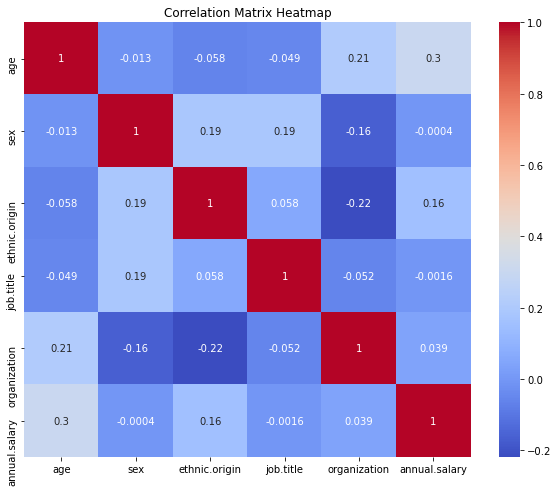

In [23]:
# Encode non-numeric columns using label encoding
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

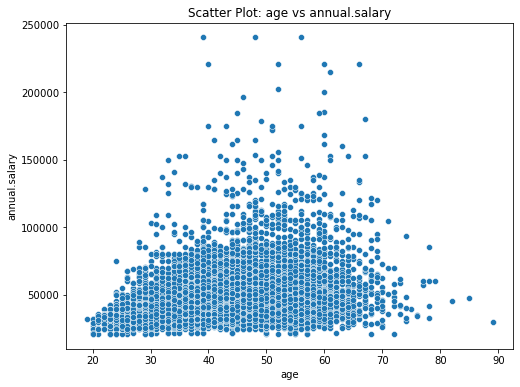

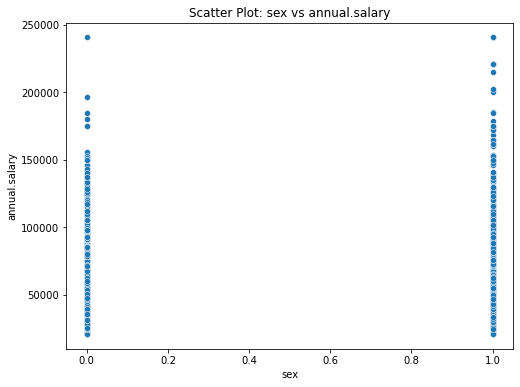

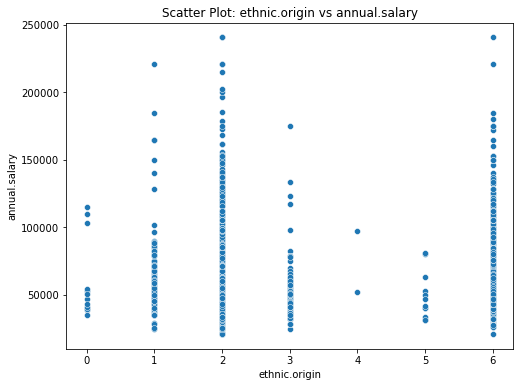

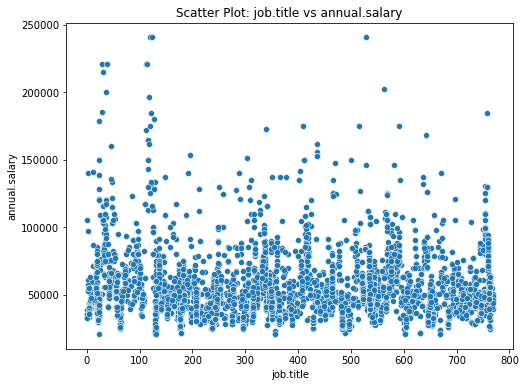

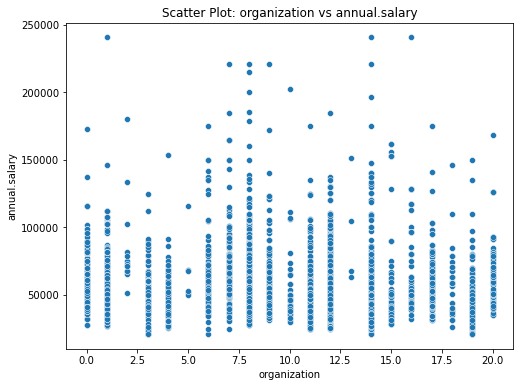

In [26]:
# Select the target variable
target_variable = 'annual.salary'

# Get the list of columns excluding the target variable
feature_columns = df.columns.drop(target_variable)

# Create scatter plots for each feature column
for column in feature_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=column, y=target_variable)
    plt.title(f'Scatter Plot: {column} vs {target_variable}')
    plt.show()

## Manipulating the Data

In [28]:
# Select the features and target variable
features = ['age', 'sex', 'ethnic.origin', 'job.title', 'organization']
target = 'annual.salary'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Create the Decision Tree Regression model
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 217072031.09571528
R^2 Score: 0.4390995651515812


In [31]:
# Create the Gradient Boosting Regression model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_y_pred = gb_model.predict(X_test)

# Evaluate the model
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

# Print the evaluation metrics
print("Gradient Boosting - Mean Squared Error:", gb_mse)
print("Gradient Boosting - R^2 Score:", gb_r2)

Gradient Boosting - Mean Squared Error: 193559660.07544667
Gradient Boosting - R^2 Score: 0.4998540486426898


## Conclusion and Recommendations